In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report


In [6]:
df = pd.read_csv("D:\\Main project\\customer-churn-prediction\\notebooks\\WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [7]:
# Prepare features and target variable
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"].map({"No": 0, "Yes": 1})


In [8]:
# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns


In [9]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [10]:
# Creating a preprocessing and modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

model = LogisticRegression(max_iter=1000)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])


In [11]:
# Training the model
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [12]:
# Evaluating baseline performance
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.8400475341651812
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


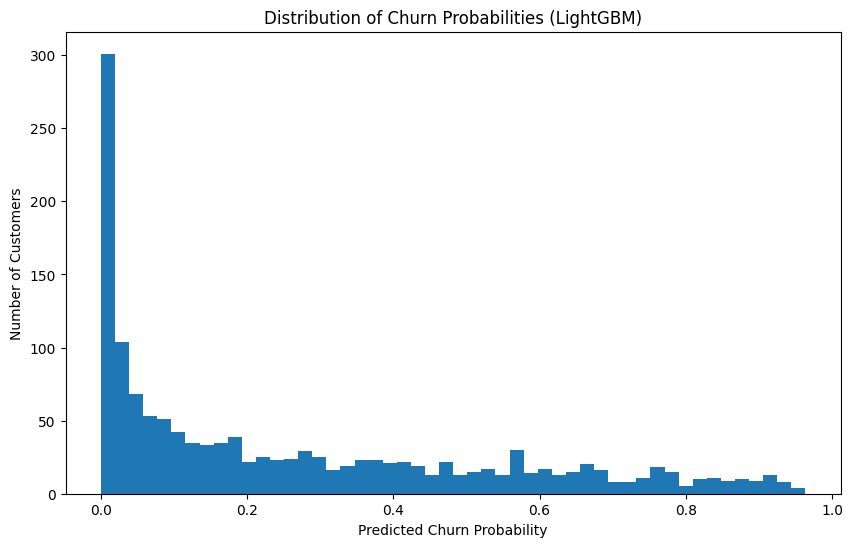

In [14]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Preprocess data for LightGBM
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train LightGBM model
lgb_model = LGBMClassifier(random_state=42, verbose=-1)
lgb_model.fit(X_train_preprocessed, y_train)

# Get predictions
y_proba_lgb = lgb_model.predict_proba(X_test_preprocessed)[:, 1]

plt.figure(figsize=(10, 6))
plt.hist(y_proba_lgb, bins=50)
plt.xlabel("Predicted Churn Probability")
plt.ylabel("Number of Customers")
plt.title("Distribution of Churn Probabilities (LightGBM)")
plt.show()



In [ ]:
# Evaluating precision and recall at different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)

results = []

for t in thresholds:
    y_pred_thresh = (y_proba_lgb >= t).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    results.append((t, precision, recall))

threshold_df = pd.DataFrame(
    results, columns=["threshold", "precision", "recall"]
)

threshold_df


,threshold,precision,recall
0,0.10,0.413835,0.911765
1,0.15,0.447332,0.874332
2,0.20,0.478939,0.820856
3,0.25,0.511226,0.791444
4,0.30,0.529528,0.719251
5,0.35,0.548807,0.676471
6,0.40,0.576060,0.617647
7,0.45,0.617143,0.577540
8,0.50,0.651613,0.540107
9,0.55,0.669118,0.486631


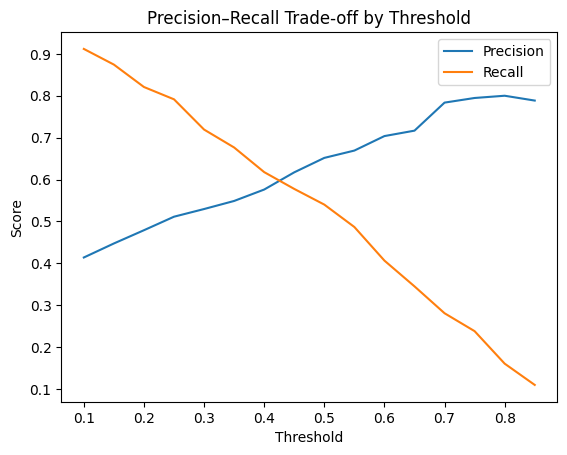

In [16]:
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall Trade-off by Threshold")
plt.show()


Based on precision–recall analysis, a churn probability threshold of 0.35 was selected.
This threshold captures approximately 82% of churners while maintaining acceptable precision, allowing the business to proactively target high-risk customers without excessive outreach cost.